# Moving Square Video Prediction Problem

In [1]:
from numpy import zeros, array
from random import randint
from random import random
from matplotlib import pyplot
%matplotlib inline
# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    # define the scope of the next step
    lower = max(0, last_step-1)
    upper = min(last_frame.shape[0]-1, last_step+1)
    # choose the row index for the next step
    step = randint(lower, upper)
    # copy the prior frame
    frame = last_frame.copy()
    # add the new step
    frame[step, column] = 1
    return frame, step


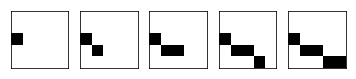

In [2]:
# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    frames = list()
    # create the first frame
    frame = zeros((size,size))
    step = randint(0, size-1)
    # decide if we are heading left or right
    right = 1 if random() < 0.5 else 0
    col = 0 if right else size-1
    frame[step, col] = 1
    frames.append(frame)
    # create all remaining frames
    for i in range(1, size):
        col = i if right else size-1-i
        frame, step = next_frame(step, frame, col)
        frames.append(frame)
    return frames, right


# generate sequence of frames
size = 5
build_frames(size)
frames, right = build_frames(size)
# plot all frames
pyplot.figure()
for i in range(size):
        # create a gray scale subplot for each frame
    pyplot.subplot(1, size, i+1)
    pyplot.imshow(frames[i], cmap='Greys')
    # turn of the scale to make it clearer
    ax = pyplot.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [3]:
# generate multiple sequences of frames and reshape for network input
# note we can reuse the size parameter as we are dealing with symmetrical images
# and the number of black squares(timesteps) go side to side.
def generate_examples(size, n_patterns):
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    # resize as [samples, timesteps, width, height, channels]
    X = array(X).reshape(n_patterns, size, size, size, 1)
    y = array(y).reshape(n_patterns, 1)
    return X, y

In [4]:
from keras.layers import Dense, TimeDistributed, LSTM, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential

Using TensorFlow backend.


In [5]:
# Model definition
size = 50

model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu'),
                          input_shape=(None,size,size,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 49, 49, 2)   10        
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 24, 24, 2)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1152)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                240600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 240,661
Trainable params: 240,661
Non-trainable params: 0
_________________________________________________________________


In [6]:
# fit model
X, y = generate_examples(size, 5000)
model.fit(X, y, batch_size=32, epochs=1, verbose=2)

Epoch 1/1
 - 23s - loss: 0.1439 - acc: 0.9292


In [7]:
# evaluate model
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0)
print('loss: %f, acc: %f' % (loss, acc*100))

loss: 0.004012, acc: 100.000000


In [9]:
# prediction on new data
X, y = generate_examples(size, 1)
yhat = model.predict_classes(X, verbose=0)
print(y,yhat)

[[1]] [[1]]
